### Importing Data

In [7]:
%%bash
pip install gdown
if [ ! -f census_income.zip ]; then
    gdown 1-PECcHuWo6wO3g6xbR2sOLOyoCWshfLS
fi
unzip -n census_income.zip

Archive:  census_income.zip


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .getOrCreate()

In [2]:
text_rdd = spark.sparkContext.textFile('adult100k')
text_rdd_cleaned = text_rdd.map(lambda x: tuple(x.split(',')))

In [3]:
schema = StructType([
    StructField("Age", StringType(), True),  
    StructField("WorkClass", StringType(), True),
    StructField("Fnlwgt", StringType(), True),
    StructField("Education", StringType(), True),
    StructField("EducationNum", StringType(), True),
    StructField("MaritalStatus", StringType(), True),
    StructField("Occupation", StringType(), True),
    StructField("Relationship", StringType(), True),
    StructField("Race", StringType(), True),
    StructField("Sex", StringType(), True),
    StructField("CapitalGain", StringType(), True),
    StructField("CapitalLoss", StringType(), True),
    StructField("HoursPerWeek", StringType(), True),
    StructField("NativeCountry", StringType(), True),
    StructField("Income", StringType(), True)
])

spark_dataframe = spark.createDataFrame(text_rdd_cleaned, schema)

In [4]:
spark_dataframe.show(5)

+---+----------------+------+---------+------------+------------------+-----------------+-------------+-----+------+-----------+-----------+------------+-------------+------+
|Age|       WorkClass|Fnlwgt|Education|EducationNum|     MaritalStatus|       Occupation| Relationship| Race|   Sex|CapitalGain|CapitalLoss|HoursPerWeek|NativeCountry|Income|
+---+----------------+------+---------+------------+------------------+-----------------+-------------+-----+------+-----------+-----------+------------+-------------+------+
| 39|       State-gov| 77516|Bachelors|          13|     Never-married|     Adm-clerical|Not-in-family|White|  Male|       2174|          0|          40|United-States| <=50K|
| 50|Self-emp-not-inc| 83311|Bachelors|          13|Married-civ-spouse|  Exec-managerial|      Husband|White|  Male|          0|          0|          13|United-States| <=50K|
| 38|         Private|215646|  HS-grad|           9|          Divorced|Handlers-cleaners|Not-in-family|White|  Male|         

### Data Exploration 

In [5]:
# How many records in this dataframe? 
num_records = spark_dataframe.count()
print('Number of records:', num_records)

Number of records: 100000


In [6]:
# Data Type Handling 
NumericalDataType = ['Age', 'Fnlwgt', 'EducationNum', 'CapitalGain', 'CapitalLoss', 'HoursPerWeek']

for col_name in NumericalDataType:
    spark_dataframe = spark_dataframe.withColumn(col_name, col(col_name).cast('float'))

In [7]:
# Missing Data / Imputations 
null_counts = spark_dataframe.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in spark_dataframe.columns))
null_counts.show()

+---+---------+------+---------+------------+-------------+----------+------------+----+---+-----------+-----------+------------+-------------+------+
|Age|WorkClass|Fnlwgt|Education|EducationNum|MaritalStatus|Occupation|Relationship|Race|Sex|CapitalGain|CapitalLoss|HoursPerWeek|NativeCountry|Income|
+---+---------+------+---------+------------+-------------+----------+------------+----+---+-----------+-----------+------------+-------------+------+
|  0|        0|     0|        0|           0|            0|         0|           0|   0|  0|          0|          0|           0|            0|     0|
+---+---------+------+---------+------------+-------------+----------+------------+----+---+-----------+-----------+------------+-------------+------+



In [8]:
# Describe the Data
spark_dataframe.describe()

DataFrame[summary: string, Age: string, WorkClass: string, Fnlwgt: string, Education: string, EducationNum: string, MaritalStatus: string, Occupation: string, Relationship: string, Race: string, Sex: string, CapitalGain: string, CapitalLoss: string, HoursPerWeek: string, NativeCountry: string, Income: string]

#### Column Descriptions 
- Age : Age of person in years (Numerical)
- WorkClass : Type of work that the person does (Catergorical)
- Fnlwgt : Final weight is the number of people the census believes the entry represents. (Numerical)
- Education : Highest Level of Education (Catergorical)
- EducationNum : Number of years completed of education (Numerical) 
- MaritalStatus : Marital status of the person (Catergorical)
- Occupation : Person's profession (Catergorical) 
- Relationship : Familial status of the person (Catergorical)
- Race : Race of person (Catergorical)
- Sex : Sex of person (Catergorical)
- CapitalGain : Capital gains for an individual (Numerical)
- CapitalLoss :  Capital loss for an individual (Numerical)
- HoursPerWeek : Hours per week that the person works (Numerical) 
- NativeCountry : Country of origin for an individual (Catergorical) 
- Income : Whether or not the person makes over or under $50k (Catergorical) 

### Data Visualization

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
sampled_df = spark_dataframe.sample(withReplacement = False, fraction = 0.001, seed = 505)
sampled_df.count()

94

#### Numerical Variables

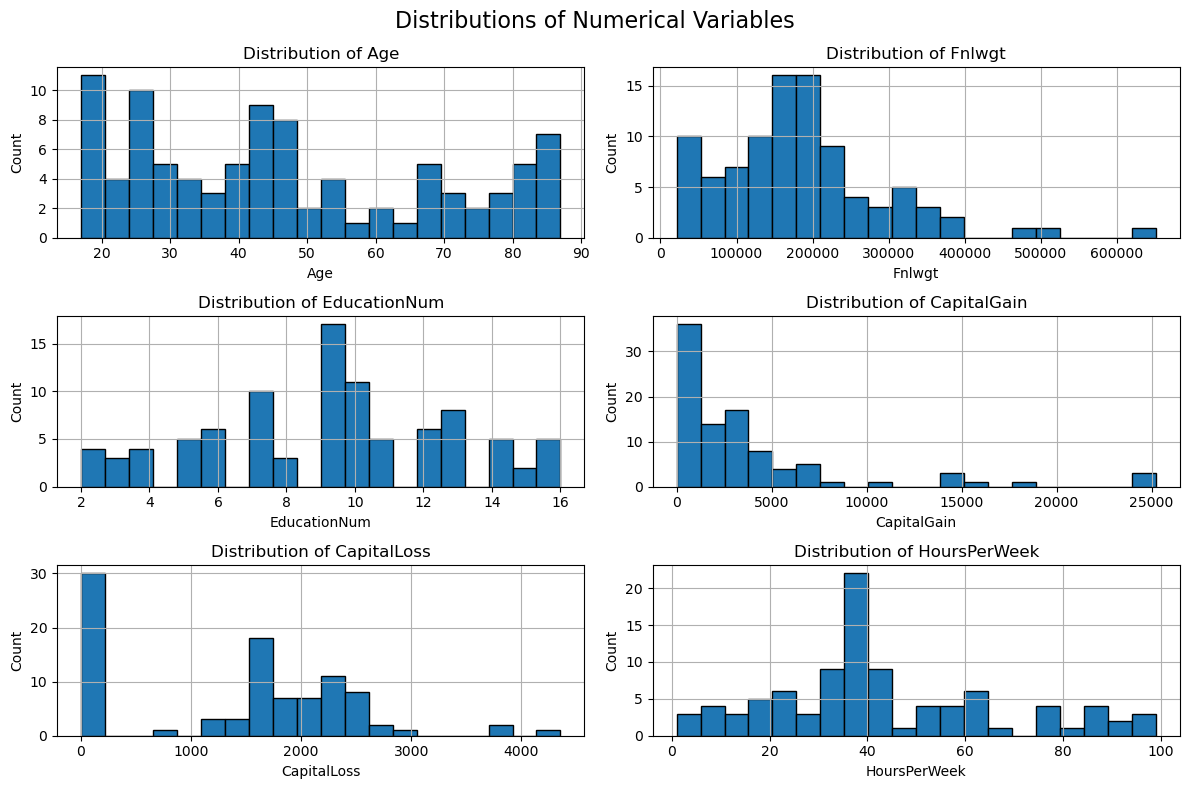

In [11]:
numerical_columns = ['Age', 'Fnlwgt', 'EducationNum', 'CapitalGain', 'CapitalLoss', 'HoursPerWeek']

# Create subplots
fig, ax = plt.subplots(3, 2, figsize=(12, 8))
fig.suptitle("Distributions of Numerical Variables", fontsize=16)

# Flatten the axes array for easier iteration
axes = ax.flatten()

# Plot histograms for each numerical column
for i, col in enumerate(numerical_columns):
    selected_data = sampled_df.select(col)
    data = selected_data.rdd.map(lambda row: row[0]).collect()
    
    if i < len(axes):
        axes[i].hist(data, bins=20, edgecolor='black')
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')
        axes[i].grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [12]:
pandas_df = sampled_df.select(numerical_columns).toPandas()

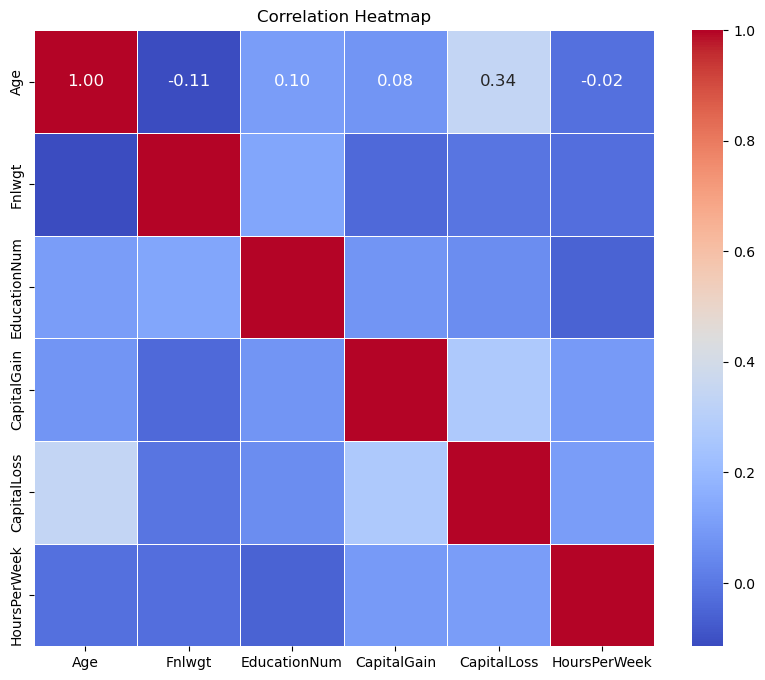

In [13]:
# Compute the correlation matrix
corr_matrix = pandas_df.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot_kws={"size": 12})
plt.title('Correlation Heatmap')
plt.show()

#### Categorical Variables

In [14]:
categorical_columns = ['WorkClass', 'Education', 'MaritalStatus', 'Occupation', 'Relationship', 'Race', 'Sex', 'Income']
categorical_columns2 = ['NativeCountry']

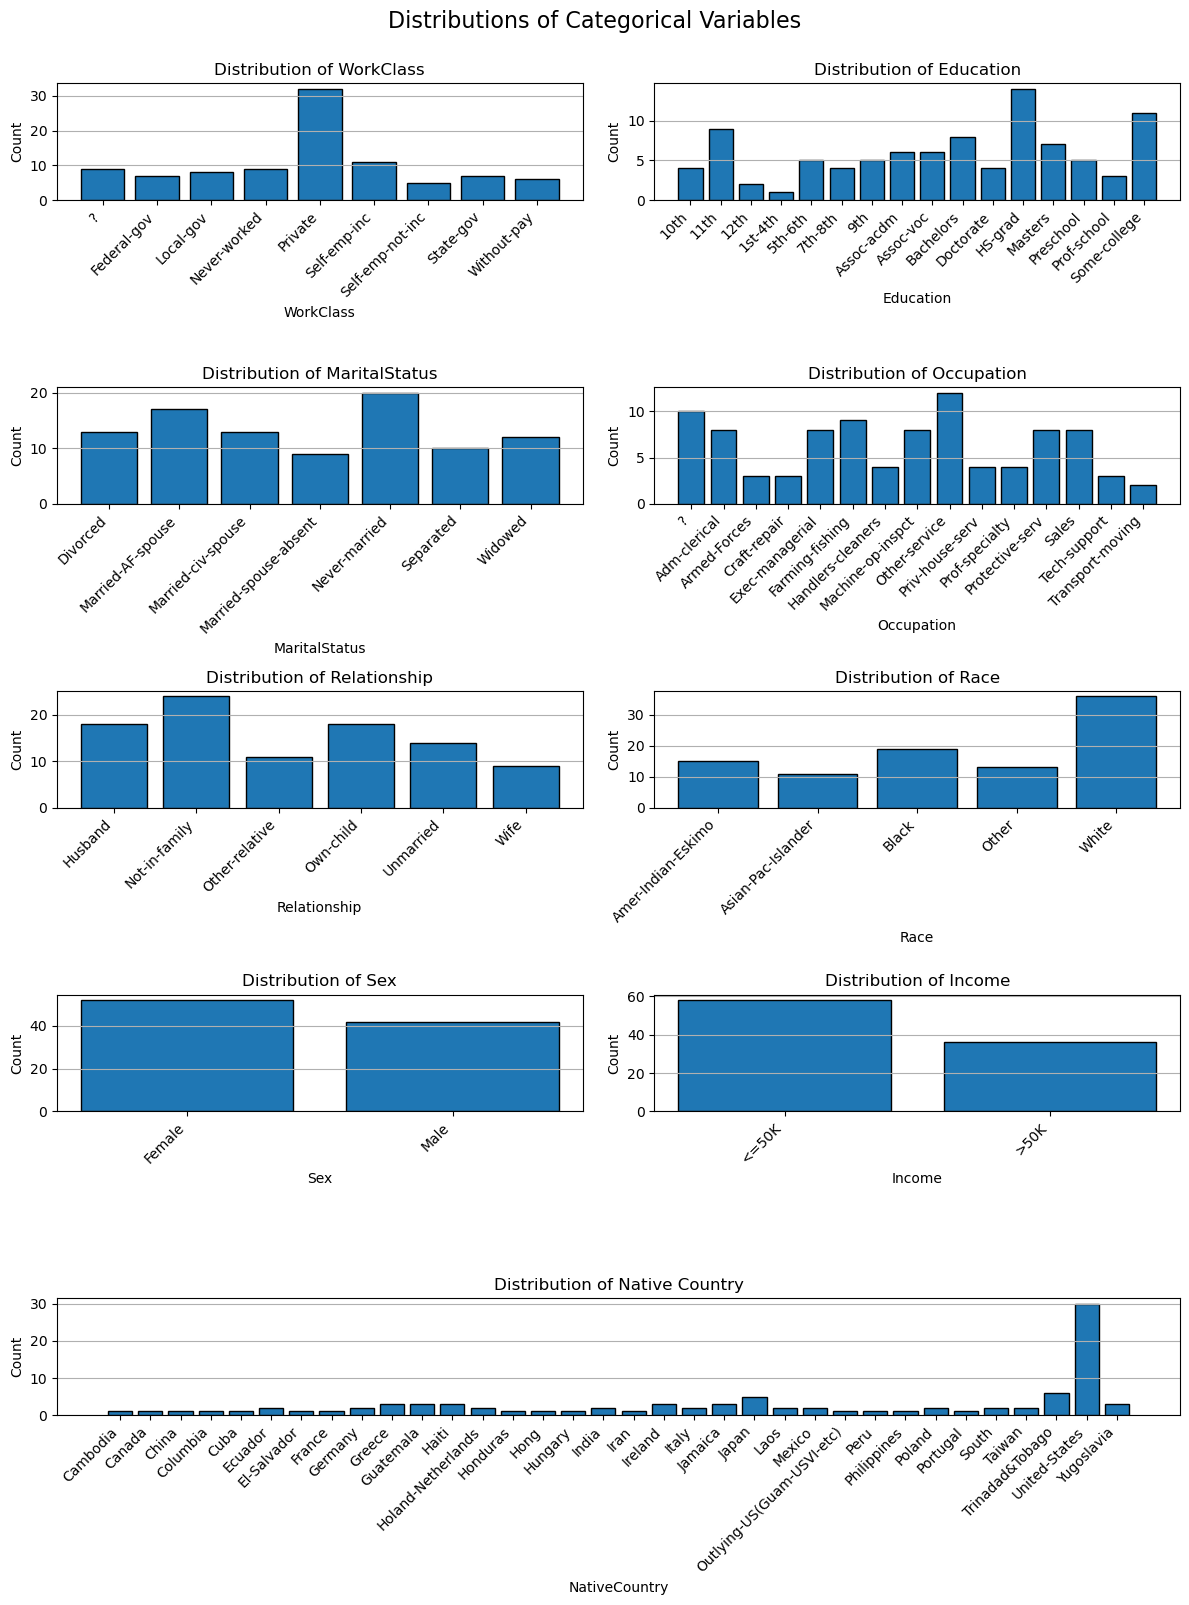

In [15]:
# Create subplots with a 4x2 grid for the categorical columns
fig, axes = plt.subplots(5, 2, figsize=(12, 16))
fig.suptitle("Distributions of Categorical Variables", fontsize=16, y=1)

# Plot bar plots for each categorical column
for i, col in enumerate(categorical_columns):
    counts = sampled_df.groupBy(col).count().orderBy(col).collect()
    categories = [str(row[col]) for row in counts]
    values = [row['count'] for row in counts]
    
    # Access the individual axes correctly
    ax = axes[i // 2, i % 2]
    ax.bar(categories, values, edgecolor='black')
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.grid(axis='y')
    
    # Set ticks and then rotate x-axis labels by 45 degrees and increase font size
    ax.set_xticks(range(len(categories)))
    ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=10)

# Plot bar plot for NativeCountry separately
counts2 = sampled_df.groupBy('NativeCountry').count().orderBy('NativeCountry').collect()
categories2 = [str(row['NativeCountry']) for row in counts2]
values2 = [row['count'] for row in counts2]

# Add a long horizontal graph at the bottom for NativeCountry
ax_bottom = plt.subplot2grid((5, 2), (4, 0), colspan=2)
ax_bottom.bar(categories2, values2, edgecolor='black')
ax_bottom.set_title('Distribution of Native Country')
ax_bottom.set_xlabel('NativeCountry')
ax_bottom.set_ylabel('Count')
ax_bottom.grid(axis='y')
ax_bottom.set_xticks(range(len(categories2)))
ax_bottom.set_xticklabels(categories2, rotation=45, ha='right', fontsize=10)

# Hide the empty subplots behind ax_bottom
for ax in axes[-1]:
    ax.set_visible(False)

# Adjust padding between subplots
plt.subplots_adjust(hspace=2)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

#### Response Variables

Education


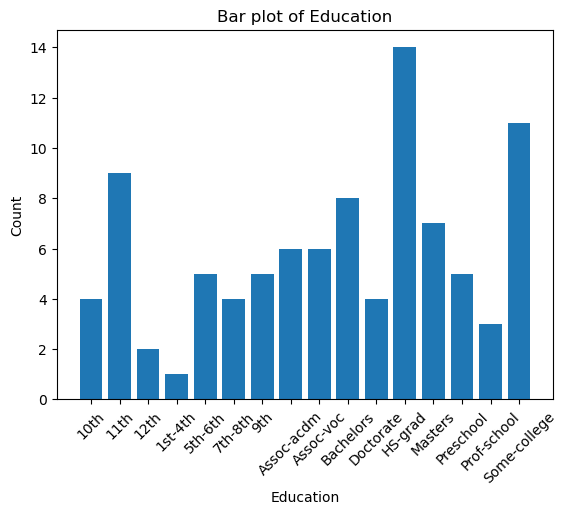

In [16]:
for i in ['Education']:

    print(i)
    value_counts = sampled_df.groupBy(i).count().orderBy(i).collect()

    values = [row[i] for row in value_counts]
    frequencies = [row['count'] for row in value_counts]

    plt.bar(values, frequencies)
    plt.xlabel(i)
    plt.ylabel('Count')
    plt.title('Bar plot of {}'.format(i))
    plt.xticks(rotation=45)
    plt.show()

### Data Preprocessing

- Numerical variables have been composed into a vector in `NumericalDataType` column
- Dataset has been split to train, test and validation set in proportions: 60/20/20
- Numerical variables vector have been scaled using `StandardScaler` to better represent normal distribution
- Categorical variables have been converted into their numerical representation
- Dataframes have been filtered to contain only transformed columnsumns

In [17]:
vector_assembler = VectorAssembler().setInputCols(NumericalDataType).setOutputCol('NumericalDataType')
spark_dataframe_transformed = vector_assembler.transform(spark_dataframe)

train_split, test_split, validation_split = spark_dataframe_transformed.randomSplit([0.6, 0.2, 0.2], seed=13)

scaler_model = StandardScaler().setInputCol('NumericalDataType').setOutputCol('NumericalDataTypeTransformed').fit(train_split)
scaled_train = scaler_model.transform(train_split)
scaled_test = scaler_model.transform(test_split)
scaled_validation = scaler_model.transform(validation_split)

scaled_train.show()

+----+---------+--------+------------+------------+--------------------+-----------------+--------------+------------------+------+-----------+-----------+------------+-------------+------+--------------------+----------------------------+
| Age|WorkClass|  Fnlwgt|   Education|EducationNum|       MaritalStatus|       Occupation|  Relationship|              Race|   Sex|CapitalGain|CapitalLoss|HoursPerWeek|NativeCountry|Income|   NumericalDataType|NumericalDataTypeTransformed|
+----+---------+--------+------------+------------+--------------------+-----------------+--------------+------------------+------+-----------+-----------+------------+-------------+------+--------------------+----------------------------+
|17.0|        ?| 34019.0|        10th|         6.0|       Never-married|                ?|     Own-child|             White|  Male|        0.0|        0.0|        20.0|United-States| <=50K|[17.0,34019.0,6.0...|        [0.84377759445743...|
|17.0|        ?| 41643.0|        11th|  

In [18]:
list_of_columns = list(spark_dataframe.columns)

CatergoricalDataType = [el for el in list_of_columns if el not in NumericalDataType]

In [19]:
string_indexer = StringIndexer(inputCols=CatergoricalDataType, outputCols=[el + "Indexed" for el in CatergoricalDataType])
indexer_model = string_indexer.fit(train_split)
indexed_train = indexer_model.transform(scaled_train)
indexed_test = indexer_model.transform(scaled_test)
indexed_validation = indexer_model.transform(scaled_validation)

indexed_train.show()

+----+---------+--------+------------+------------+--------------------+-----------------+--------------+------------------+------+-----------+-----------+------------+-------------+------+--------------------+----------------------------+----------------+----------------+--------------------+-----------------+-------------------+-----------+----------+--------------------+-------------+
| Age|WorkClass|  Fnlwgt|   Education|EducationNum|       MaritalStatus|       Occupation|  Relationship|              Race|   Sex|CapitalGain|CapitalLoss|HoursPerWeek|NativeCountry|Income|   NumericalDataType|NumericalDataTypeTransformed|WorkClassIndexed|EducationIndexed|MaritalStatusIndexed|OccupationIndexed|RelationshipIndexed|RaceIndexed|SexIndexed|NativeCountryIndexed|IncomeIndexed|
+----+---------+--------+------------+------------+--------------------+-----------------+--------------+------------------+------+-----------+-----------+------------+-------------+------+--------------------+--------

In [20]:
preprocessed_columns = [el + "Indexed" for el in CatergoricalDataType] + ['NumericalDataTypeTransformed']
train = indexed_train.select(preprocessed_columns)
test = indexed_test.select(preprocessed_columns)
validation = indexed_validation.select(preprocessed_columns)

train.show()

+----------------+----------------+--------------------+-----------------+-------------------+-----------+----------+--------------------+-------------+----------------------------+
|WorkClassIndexed|EducationIndexed|MaritalStatusIndexed|OccupationIndexed|RelationshipIndexed|RaceIndexed|SexIndexed|NativeCountryIndexed|IncomeIndexed|NumericalDataTypeTransformed|
+----------------+----------------+--------------------+-----------------+-------------------+-----------+----------+--------------------+-------------+----------------------------+
|             3.0|             7.0|                 1.0|              7.0|                2.0|        0.0|       0.0|                 0.0|          0.0|        [0.84377759445743...|
|             3.0|             5.0|                 1.0|              7.0|                2.0|        0.0|       1.0|                 0.0|          0.0|        [0.84377759445743...|
|             3.0|             5.0|                 1.0|              7.0|                

### Data Download and Requirements

- Data can be downloaded off : https://www.kaggle.com/datasets/brijeshbmehta/adult-datasets